In [824]:
import sys
sys.path.append('../modules')
from mask import *
from gridding import *

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [825]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
dv = 'Rain-RL50'
ds = read_data(PATH, dv)

In [826]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

mask = gen_raster_mask_from_vector(ds.rlon, ds.rlat, canada)

In [889]:
ens_mean = ds[dv].values.mean(axis=0)
ens_mean.shape

(130, 155)

In [890]:
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
rlat[final_mask].shape, rlon[final_mask].shape, ens_mean[final_mask].shape

((4087,), (4087,), (4087,))

In [891]:
t1, t2 = np.deg2rad(ds.lat.values[final_mask].min()), np.deg2rad(ds.lat.values[final_mask].max())
l1, l2 = -np.deg2rad((ds.lon.values[final_mask]).min()-360), -np.deg2rad((ds.lon.values[final_mask]).max()-360)

print("l1", np.rad2deg(l1), "l2", np.rad2deg(l2), (t1), (t2))

def loncos(l, l1, l2):
    return np.cos(2*np.pi*(l1-l)/(l1-l2))
    
def latcos(t, t1, t2):
    return np.cos(2*np.pi*(t-t1)/(t2-t1))
    
def f1(x):
    if (l2 <= x) & (x<= (l1+l2)/2.):
        return 0.
    elif ((l1+l2)/2. < x) & (x <= l1):
        return (loncos(x, l1, l2)+1)/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g1(x):
    if (t1 <= x) & (x <= (t1+t2)/2.):
        return (latcos(x, t1, t2)+1)/2.
    elif ((t1+t2)/2. < x) & (x <= t2):
        return 0.
    else:
        print(t1, t2, x)
        raise NameError("Did not meet stop criterion.")
        
def f2(x):
    if (l2 <= x) & (x<=l1):
        return (1-loncos(x, l1, l2))/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g2(x): 
    if (t1 <=  x) & (x <= t2):
        return (1-latcos(x, t1, t2))/2.
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
def f3(x):
    if (l2 <= x) & (x <= (l1+l2)/2):
        return (loncos(x, l1, l2)+1)/2.
    elif ((l1+l2)/2 < x) & (x <= l1):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g3(x):
    if (t1 <= x) & (x <= (t1+t2)/2):
        return 0.
    elif (((t1+t2)/2) < x) & (x <= t2):
        return (latcos(x, t1, t2)+1)/2 
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
    
def g(m, t):
    if m == 1:
        return g1(t)
    if m == 2:
        return g2(t)
    if m == 3:
        return g3(t)
def f(n, l):
    if n == 1:
        return f1(l)
    if n == 2:
        return f2(l)
    if n == 3:
        return f3(l)
    
hmn = np.ones((3, 3))
def h(t, l):
    for n in np.arange(1, 4):
        for m in np.arange(1, 4):
            hmn[m-1, n-1] = g(m, t)*f(n, l)
    return hmn

l1 140.92741394042972 l2 53.037811279296875 0.7353188838371078 1.320439077461218


((130, 155), (130, 155))

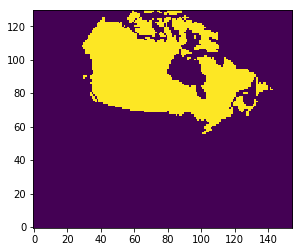

In [892]:
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten()) 
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)


bdry_mask_lon = (np.deg2rad(ds.lon.values) < l2) & ((np.deg2rad(ds.lon.values) > l1))
bdry_mask_lat = (np.deg2rad(ds.lat.values) < t2) & ((np.deg2rad(ds.lat.values) > t1))

master_bdry_mask = np.logical_or(bdry_mask_lon, bdry_mask_lat)
master = np.logical_and(final_mask, master_bdry_mask)

lon, lat = np.deg2rad(-(ds.lon.values-360)), np.deg2rad(ds.lat.values)
lon.min(), lon.max()
plt.imshow(master, origin='lower')
lon.shape, lat.shape

In [893]:
master.shape

(130, 155)

In [894]:
# Populate the entries of the 3x3 matrix for h_mn 
d = np.ones((ens_mean.flatten().shape[0], hmn.shape[0], hmn.shape[1]))
d_raw = np.ones((ens_mean.flatten().shape[0], hmn.shape[0], hmn.shape[1]))

print(d.shape, ens_mean[master].shape, ens_mean.flatten().shape, master.flatten().shape)

for i, cell in enumerate(ens_mean.flatten()):
    if master.flatten()[i]:
        cell = np.broadcast_to(cell, (hmn.shape))
        d[i] = np.multiply(cell, h(lat.flatten()[i], lon.flatten()[i]))
        d_raw[i] = h(lat.flatten()[i], lon.flatten()[i])
    else:
        d[i] = np.full(hmn.shape, np.nan)
        d_raw[i] = np.full(hmn.shape, np.nan)

(20150, 3, 3) (4085,) (20150,) (20150,)


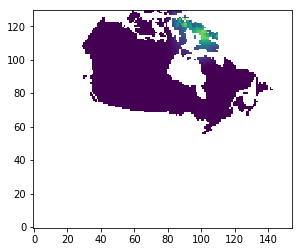

In [895]:
# re grid to og grids
d_grid = d.reshape((ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0]*hmn.shape[1]))
d_raw_grid = d_raw.reshape((ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0]*hmn.shape[1]))

np.all(np.isnan(d_grid))
plt.imshow(d_grid[:, :, 8], origin='lower')

In [896]:
df = pd.read_csv('/storage/home/nannau/Interim_snow_rain_load_LRstations_delivered_hist.csv', index_col=None)
df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa),rlon,rlat
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763,-17.245771,4.407283
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571,-17.148280,4.041212
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795,-17.269400,4.110152
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371,-17.157965,3.823732
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565,-18.602266,6.674747


In [897]:
master.shape

(130, 155)

In [898]:
x = np.linspace(0, 10, 10)

def find_nearest(data, val):
    lo, hi = 0, len(data) - 1
    best_ind = lo
    while lo <= hi:
        mid = int(lo + (hi - lo) / 2)
        if data[mid] < val:
            lo = mid + 1
        elif data[mid] > val:
            hi = mid - 1
        else:
            best_ind = mid
            break
        # check if data[mid] is closer to val than data[best_ind] 
        if abs(data[mid] - val) < abs(data[best_ind] - val):
            best_ind = mid
    return best_ind

In [899]:
rlat_i = np.array([find_nearest(ds.rlat.values, obs) for obs in df.rlat.values])
rlon_i = np.array([find_nearest(ds.rlon.values, obs) for obs in df.rlon.values])

In [900]:
values = d_grid[rlat_i, rlon_i, ...]
# values[~np.isnan(values[:, 0])]
nanmask = ~np.isnan(values)[:, 0]
nanmask

df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
df['nearest_grid'] = list(zip(rlon_i, rlat_i))

ndf = ndf.groupby('nearest_grid').agg({
                                    station_dv: 'mean',
                                    'lat':'min',
                                    'lon':'min',
                                    'rlat':'min',
                                    'rlon':'min',
                                    'rlat_nearest':'min',
                                    'rlon_nearest':'min'
                                })
ndf = ndf[ndf['RL50 (kPa)'] != 0.0]
ndf.head()

,RL50 (kPa),lat,lon,rlat,rlon,rlat_nearest,rlon_nearest
nearest_grid,,,,,,,
"(30, 91)",0.542,54.2552,-133.058,11.545164,-20.545368,11.440001,-20.679993
"(31, 85)",0.460,51.9333,-131.017,8.922110,-20.436114,8.800001,-20.239990
"(31, 88)",0.478,53.2539,-131.813,10.323304,-20.314454,10.120001,-20.239990
"(33, 81)",0.468,50.7822,-128.427,7.217537,-19.408809,7.040001,-19.360016
"(33, 87)",0.962,53.0500,-129.683,9.606713,-19.221121,9.680001,-19.360016


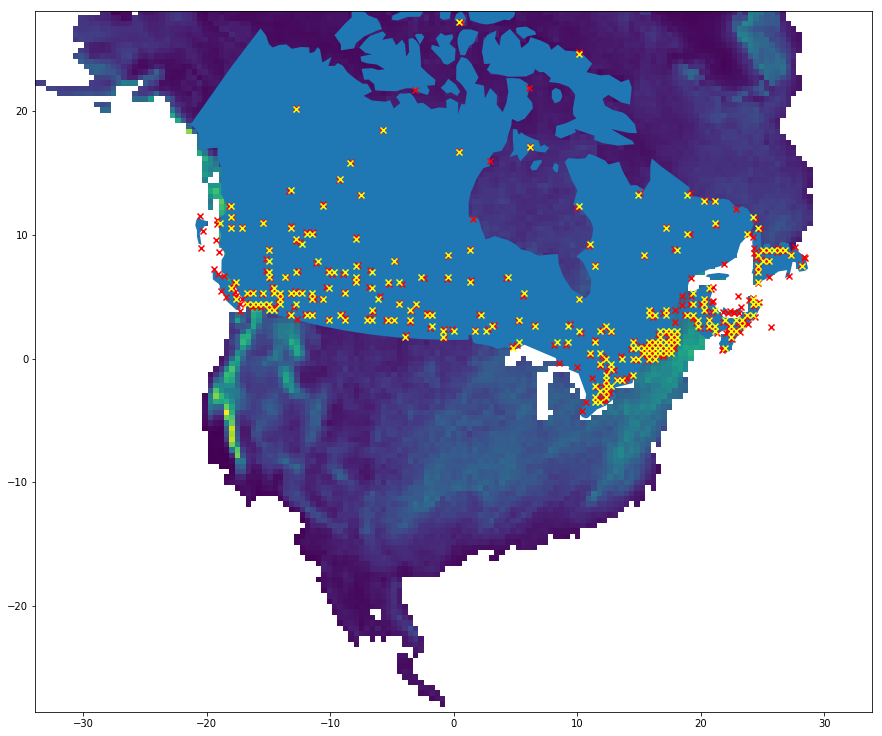

In [901]:
def find_nearest(data, val):
    lo, hi = 0, len(data) - 1
    best_ind = lo
    while lo <= hi:
        mid = int(lo + (hi - lo) / 2)
        if data[mid] < val:
            lo = mid + 1
        elif data[mid] > val:
            hi = mid - 1
        else:
            best_ind = mid
            break
        # check if data[mid] is closer to val than data[best_ind] 
        if abs(data[mid] - val) < abs(data[best_ind] - val):
            best_ind = mid
    return best_ind

# this finds the nearest grid cells from the rotated lat and lon arrays in the models 
rlat_i = np.array([find_nearest(ds.rlat.values, obs) for obs in ndf.rlat.values])
rlon_i = np.array([find_nearest(ds.rlon.values, obs) for obs in ndf.rlon.values])

# this gets the value at the indices nearest to the stations
values = d_grid[rlat_i, rlon_i, ...]
# this marks the values at these indices that are NaN, or outside of the coastline
nanmask = ~np.isnan(values)[:, 0]

fig, ax = plt.subplots(figsize=(15, 15))
# this plots canada
canada.plot(ax=ax)
# this plots the stations
ax.scatter(ndf.rlon.values, ndf.rlat.values, color='red', marker='x')
# this plots the nearest grids to the stations
ax.scatter(ds.rlon.values[rlon_i][nanmask], ds.rlat.values[rlat_i][nanmask], color='yellow', marker='x')
# this plots a raw model instance
ax.imshow(ds[dv].values[0, ...], origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()])
plt.savefig('nearest_stations')

In [902]:
# df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
# df['nearest_grid'] = list(zip(rlon_i, rlat_i))

In [925]:
from scipy.interpolate import NearestNDInterpolator 
# NearestNDInterpolator(values[0, ...])
# print(values[:, 0][nanmask])
coordict = rlat_rlon_to_ens(ds.rlat.values, ds.rlon.values)
rlat_ens, rlon_ens = coordict['rlat'][master.flatten()], coordict['rlon'][master.flatten()]
d_grid[master].shape, rlat_ens.shape
interp = NearestNDInterpolator(np.array(list(zip(rlon_ens, rlat_ens))), d_grid[master])
values[~nanmask, :] = interp(np.array(list(zip(ndf.rlon_nearest[~nanmask], ndf.rlat_nearest[~nanmask]))))

In [926]:
ndf.head()

,RL50 (kPa),lat,lon,rlat,rlon,rlat_nearest,rlon_nearest
nearest_grid,,,,,,,
"(30, 91)",0.542,54.2552,-133.058,11.545164,-20.545368,11.440001,-20.679993
"(31, 85)",0.460,51.9333,-131.017,8.922110,-20.436114,8.800001,-20.239990
"(31, 88)",0.478,53.2539,-131.813,10.323304,-20.314454,10.120001,-20.239990
"(33, 81)",0.468,50.7822,-128.427,7.217537,-19.408809,7.040001,-19.360016
"(33, 87)",0.962,53.0500,-129.683,9.606713,-19.221121,9.680001,-19.360016


In [927]:
values.shape, ndf['RL50 (kPa)'].values.shape

((292, 9), (292,))

0.7197760218330527
slope of plot 0.7197759600998966 r2_val of plot 0.848396146757549


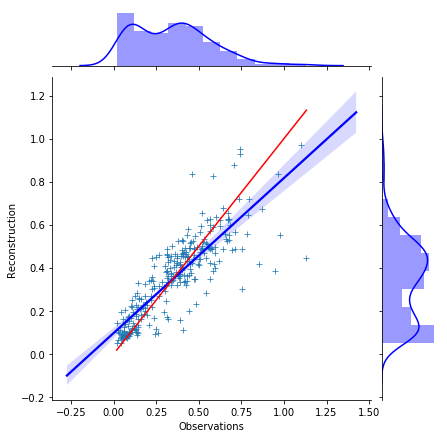

In [964]:
nanmean = ~np.isnan(ens_mean[rlat_i, rlon_i])
mean = ens_mean[rlat_i, rlon_i].copy()
mean[~nanmean] = interp_mean(np.array(list(zip(ndf.rlon_nearest[~nanmean], ndf.rlat_nearest[~nanmean]))))

mean, interp_mean(np.array(list(zip(ndf.rlon_nearest[~nanmean], ndf.rlat_nearest[~nanmean]))))
X, Y = mean.reshape(-1, 1), ndf['RL50 (kPa)'].values

model = fit_eof(X, Y)
print(model.score(X, Y))

from scipy.stats import linregress

sns.jointplot(Y, model.predict(X), kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y, model.predict(X), marker='+')
sns.lineplot(Y, Y, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(Y, model.predict(X))
print("slope of plot", slope, "r2_val of plot", r_value)

In [884]:
X, Y = values, ndf['RL50 (kPa)'].values

In [885]:
from eof import *
model = fit_eof(X, Y)

### EOF Regression Score:

In [886]:
model.score(X, Y)

0.7549044066790566

slope 0.7549044066790574 r2_val 0.8688523503329301


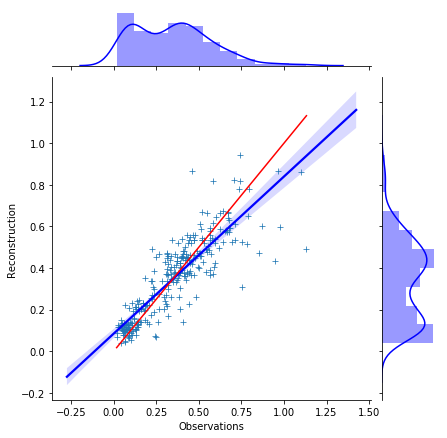

In [859]:
from scipy.stats import linregress

sns.jointplot(Y, model.predict(X), kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y, model.predict(X), marker='+')
sns.lineplot(Y, Y, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(Y, model.predict(X))
print("slope of plot", slope, "r2_val of plot", r_value)

In [860]:
model.predict(d_grid[master]).shape

(4085,)

In [861]:
dc = d_grid[..., 0].flatten().copy()
dc[master.flatten()] = model.predict(d_grid[master])

In [862]:
final = dc.reshape(d_grid[..., 0].shape)

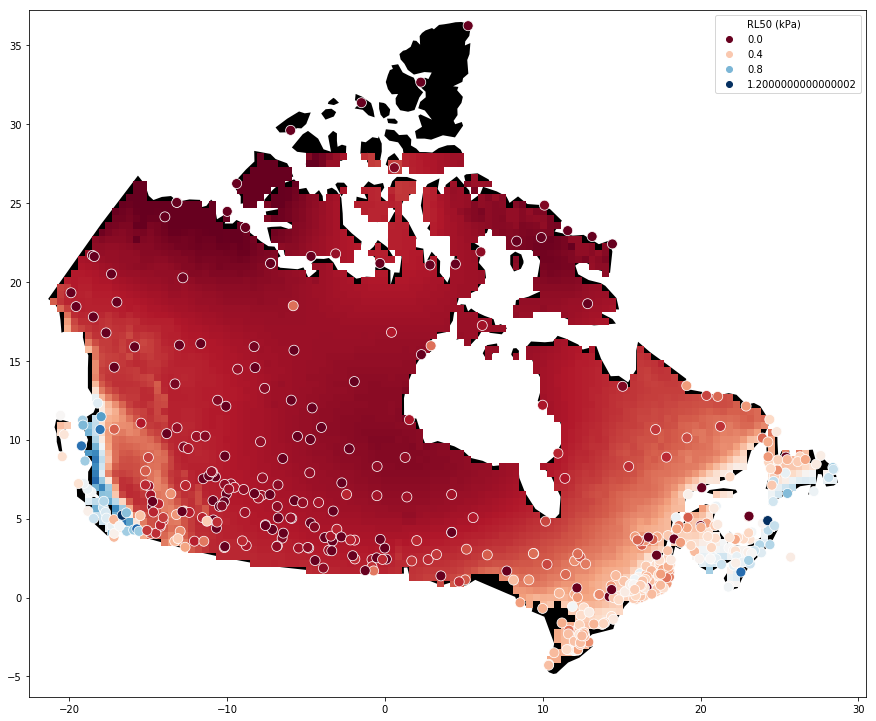

In [863]:
fig, ax = plt.subplots(figsize=(15, 15))
# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., 1.1
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='RdBu', s=100, edgecolor='white', hue_norm=(vmin, vmax))
ax.imshow(final, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap='RdBu', vmin=vmin, vmax=vmax)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

In [864]:
from scipy import interpolate
final.flatten().shape
coordict_ens = rlat_rlon_to_ens(ds.rlat.values, ds.rlon.values)
rlat_ens, rlon_ens = coordict_ens['rlat'], coordict_ens['rlon']

In [865]:
irlat, irlon = np.linspace(rlat.min(), rlat.max(), rlat.shape[0]*10), np.linspace(rlon.min(), rlon.max(), rlon.shape[1]*10)
print(irlat.shape, irlon.shape)
icoordict = rlat_rlon_to_ens(irlat, irlon)
points = list(zip(icoordict['rlon'], icoordict['rlat']))

from scipy.interpolate import LinearNDInterpolator
np.array(list(zip(rlon_ens, rlat_ens))), d_grid[master], final[master].flatten()

iff = LinearNDInterpolator(list(zip(rlon_ens, rlat_ens)), final.flatten())
ifinal = iff(points)

(1300,) (1550,)


In [866]:
ifinal = ifinal.reshape(irlat.shape[0], irlon.shape[0])

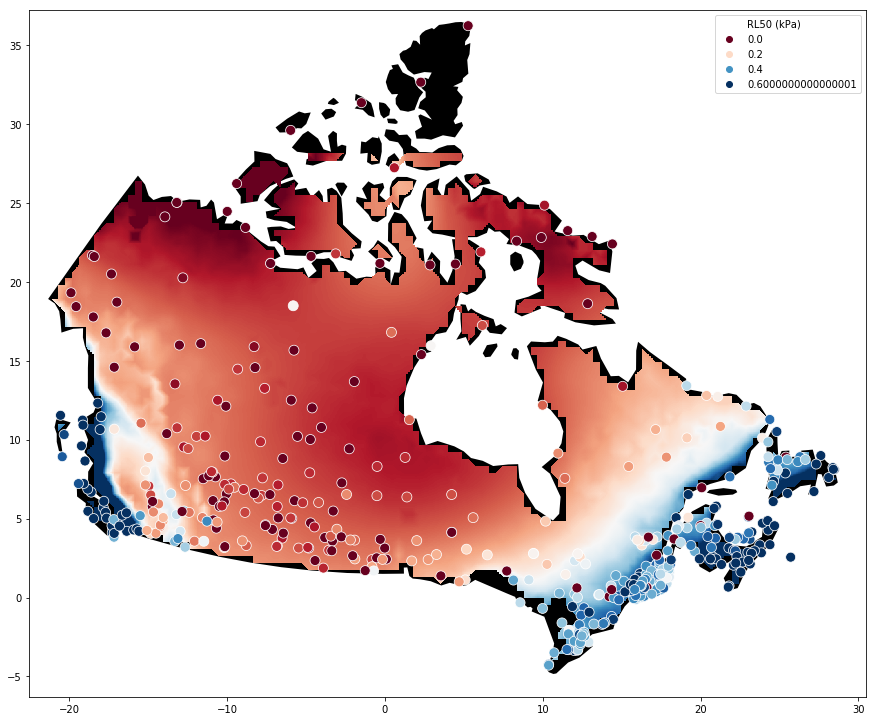

In [867]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='RdBu', s=100, edgecolor='white', hue_norm=(vmin, vmax))
ax.imshow(ifinal, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap='RdBu', vmin=vmin, vmax=vmax)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

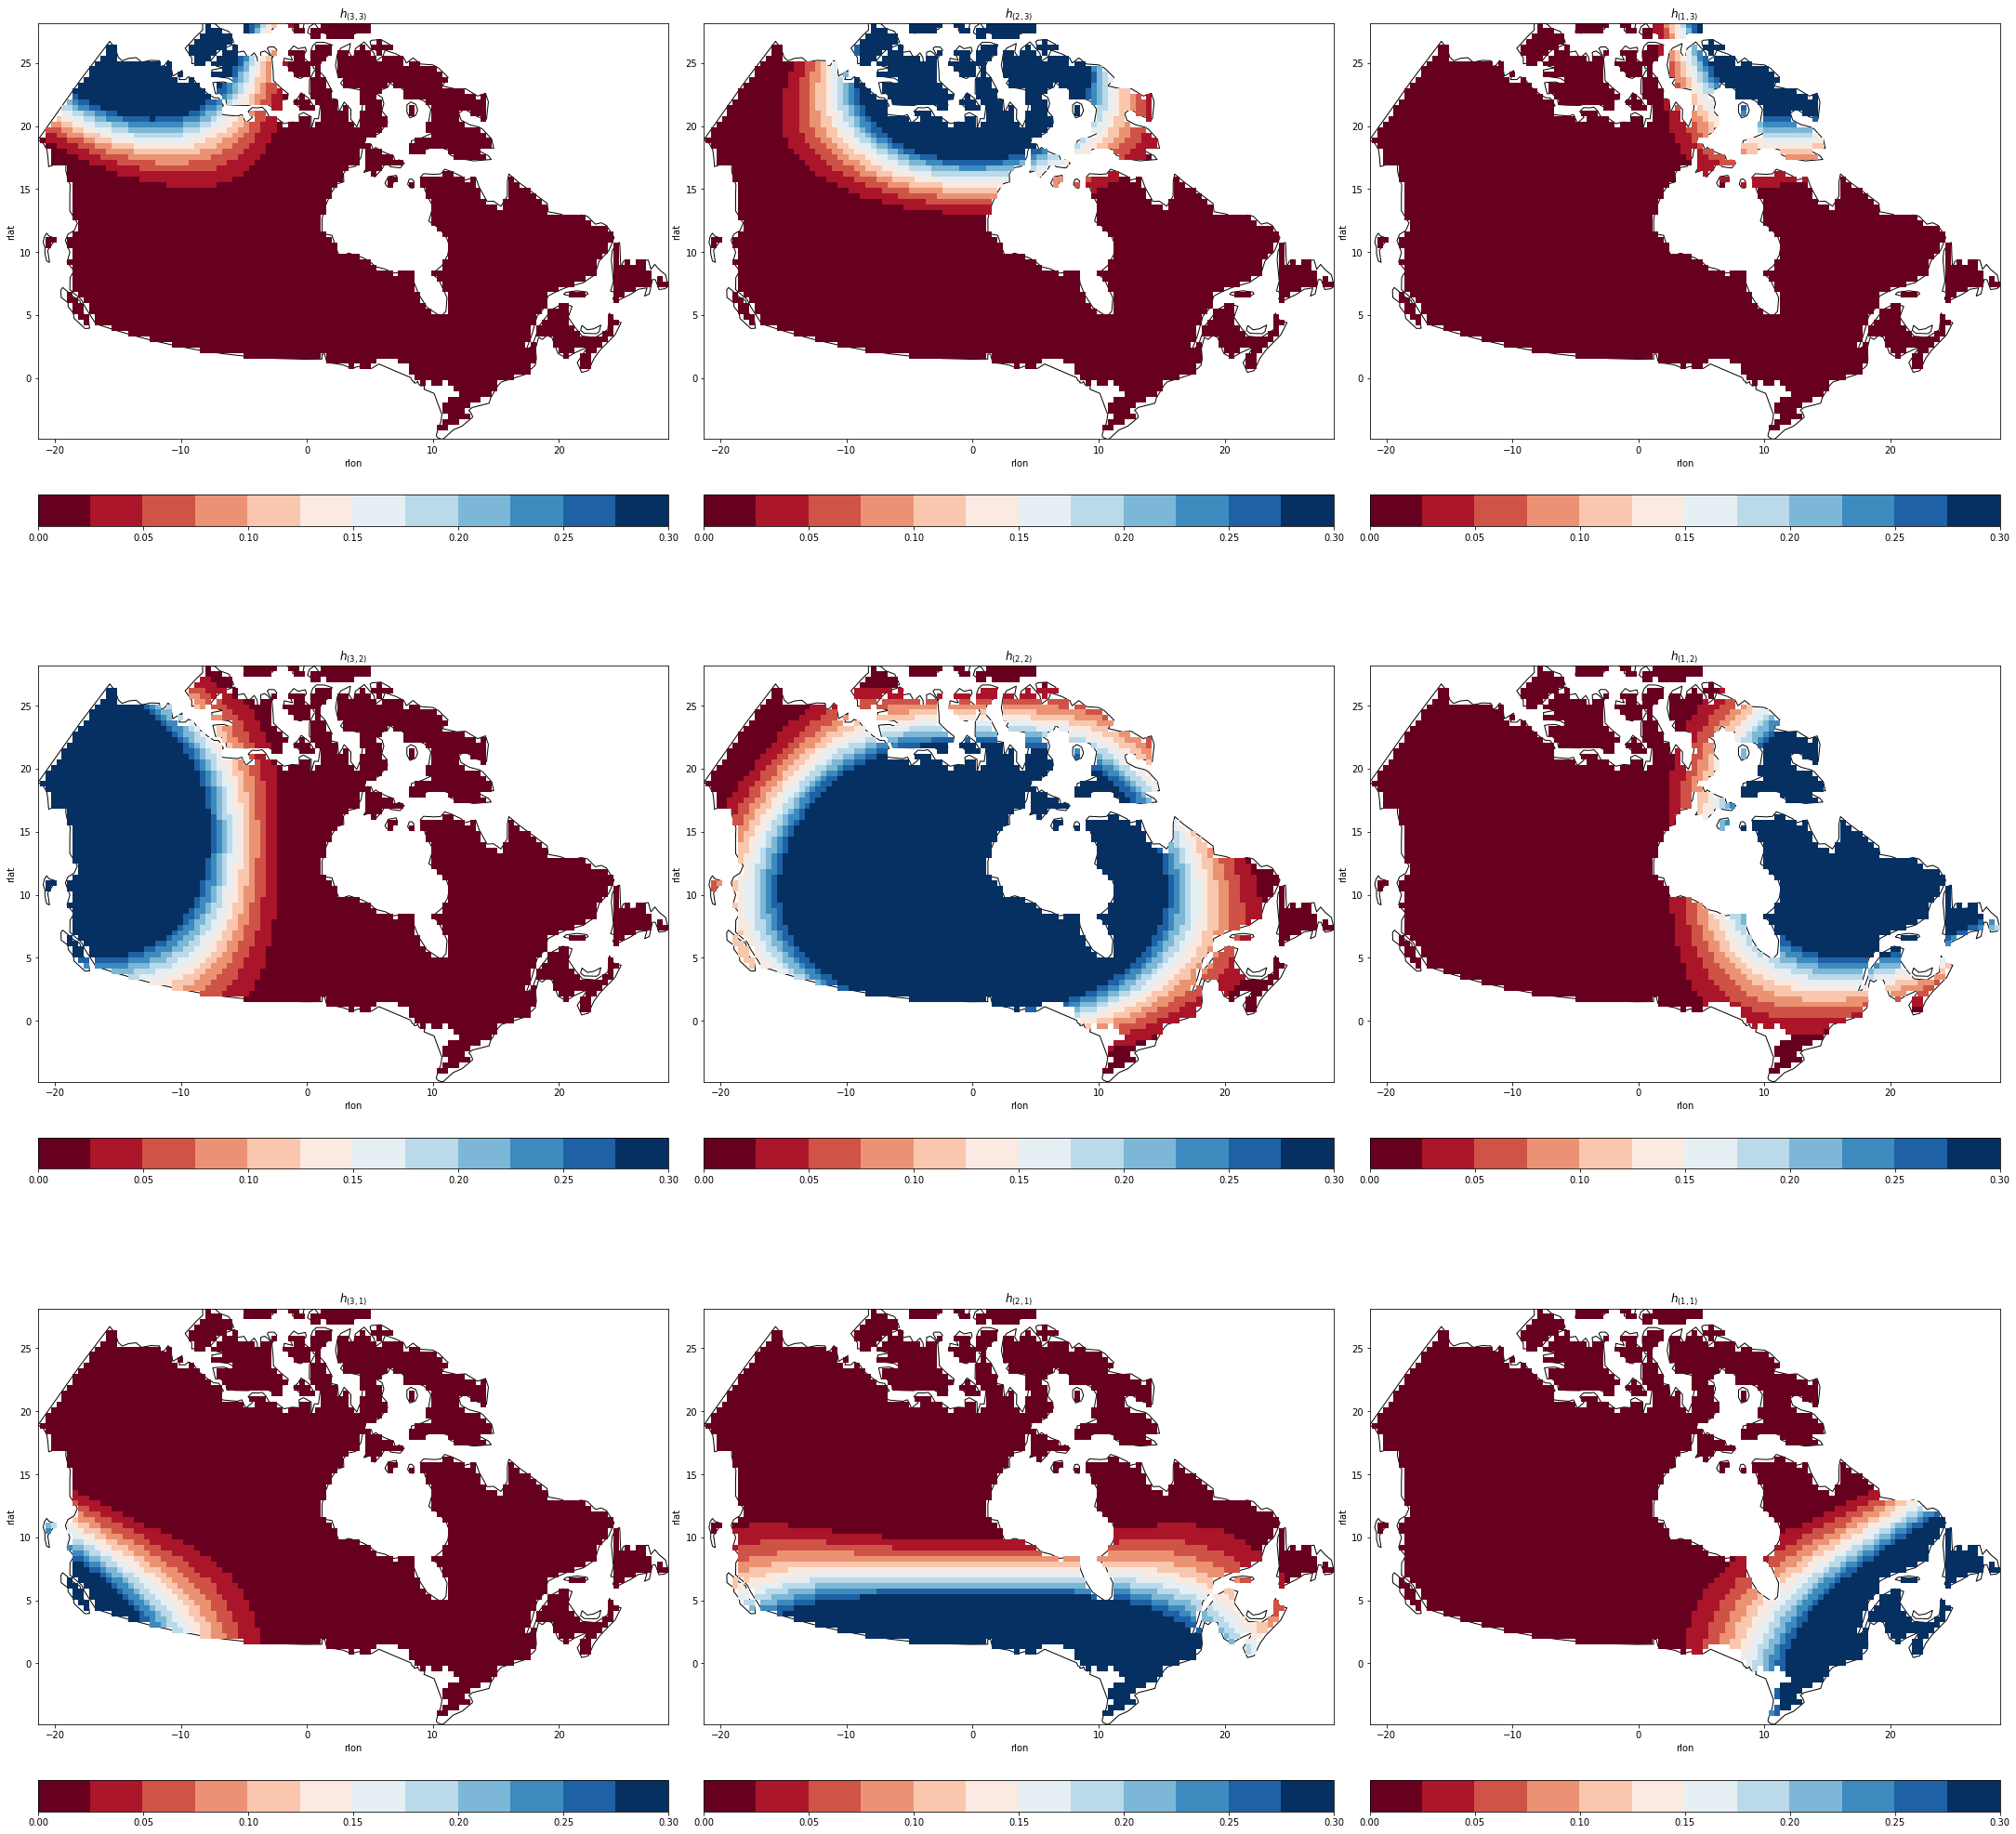

In [871]:
fig, ax = plt.subplots(3, 3, figsize=(30,30))

tuples = [(3,1),(2,1),(1,1),(3,2),(2,2),(1,2),(3,3),(2,3),(1,3)]

tu = [tuple(x) for x in (np.array(tuples) - 1)]
tu.reverse()
tu = [(x[1], x[0]) for x in tu]

x1, x2, y1, y2 = irlon.min(), irlon.max(), irlat.min(), irlat.max()


for i, t in enumerate(tu):

    ax[t].set_title('$h_{%s}$' % (tuples[i],))
    ax[t].set_xlabel('rlon')
    ax[t].set_ylabel('rlat')
    ax[t].set_ylim(canada.bounds.miny.values[0], y2)
    ax[t].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[t], color='white', edgecolor='black', zorder=1)
    
    X = d_raw_grid[:, :, i]
    
    img = ax[t].imshow(X, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern',vmin=vmin, vmax=vmax, zorder=2,extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[t], fraction=0.046, pad=0.08)
plt.tight_layout(pad=0.6, h_pad=.2, w_pad=0.1)
plt.savefig('raw_patterns.pdf')

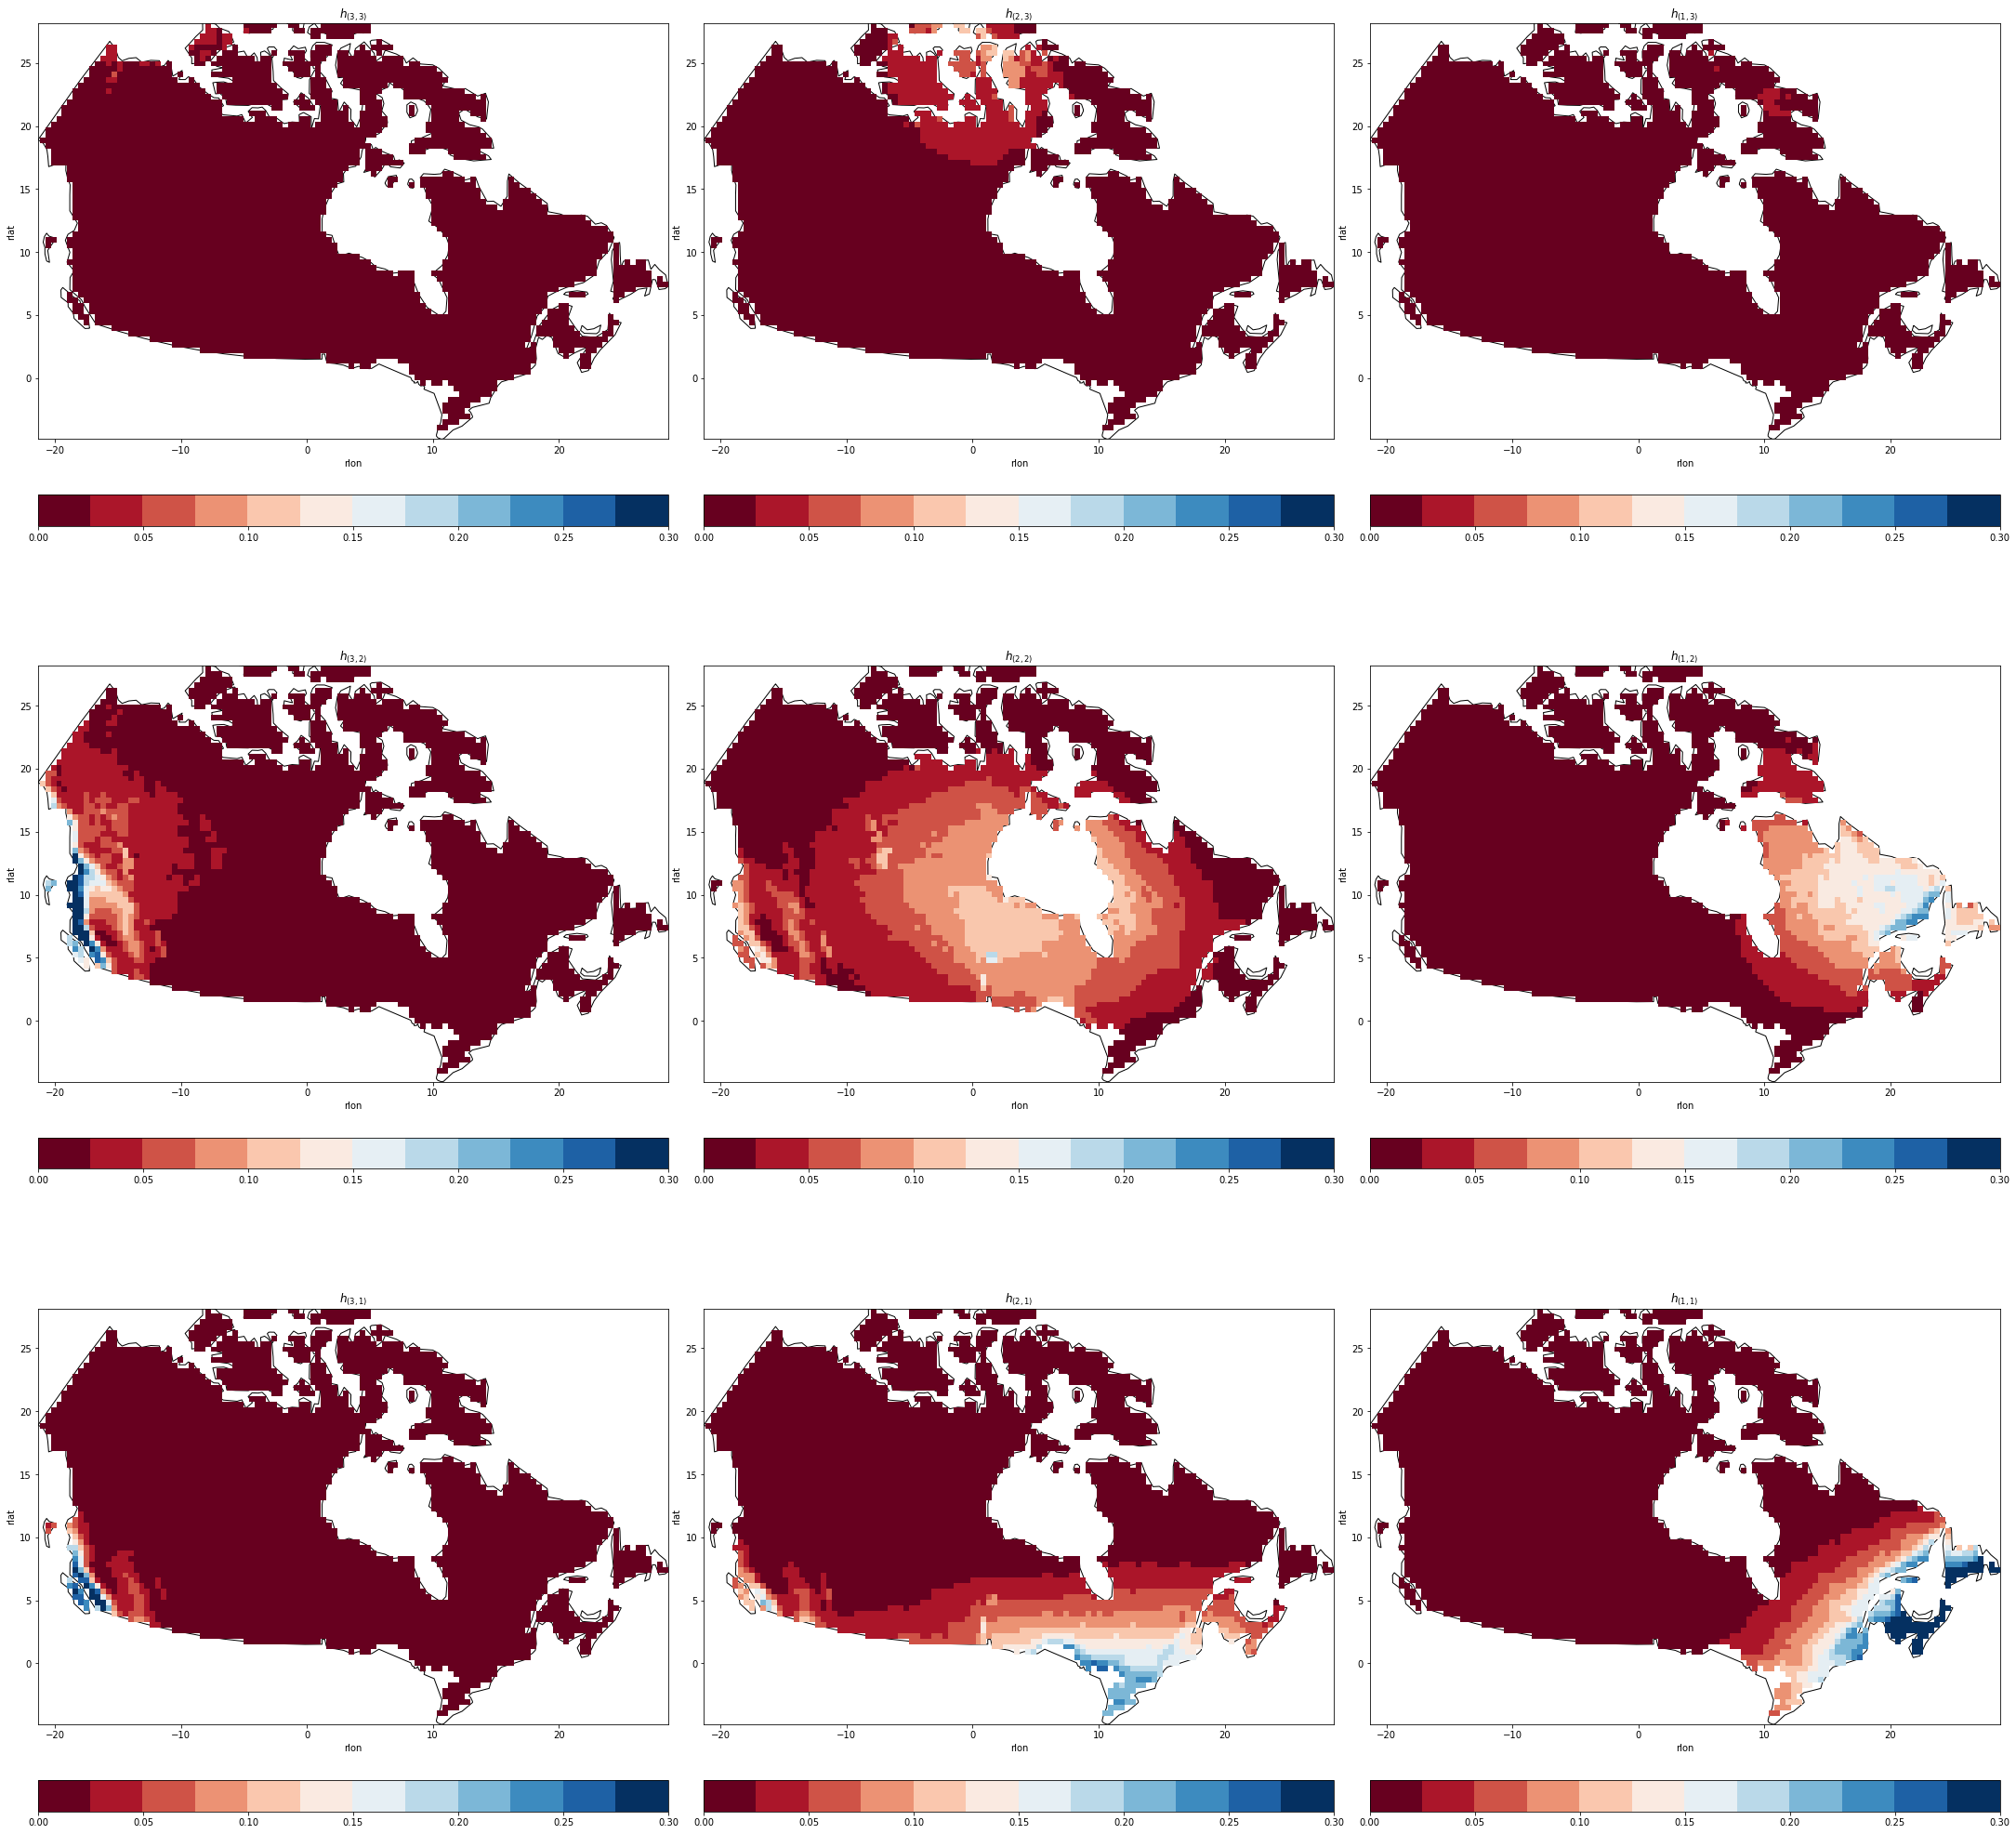

In [872]:
fig, ax = plt.subplots(3, 3, figsize=(30,30))

tuples = [(3,1),(2,1),(1,1),(3,2),(2,2),(1,2),(3,3),(2,3),(1,3)]

tu = [tuple(x) for x in (np.array(tuples) - 1)]
tu.reverse()
tu = [(x[1], x[0]) for x in tu]

x1, x2, y1, y2 = irlon.min(), irlon.max(), irlat.min(), irlat.max()

vmin, vmax = 0., .3

for i, t in enumerate(tu):

    ax[t].set_title('$h_{%s}$' % (tuples[i],))
    ax[t].set_xlabel('rlon')
    ax[t].set_ylabel('rlat')
    ax[t].set_ylim(canada.bounds.miny.values[0], y2)
    ax[t].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[t], color='white', edgecolor='black', zorder=1)
    
    X = d_grid[:, :, i]
    
    img = ax[t].imshow(X, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern',vmin=vmin, vmax=vmax, zorder=2,extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[t], fraction=0.046, pad=0.08)
plt.tight_layout(pad=0.6, h_pad=.2, w_pad=0.1)   
plt.savefig('patterns.pdf')